## Validating Fastai classifier with Yelowbrick

- [Yellowbrick](https://www.scikit-yb.org/en/latest/index.html) extends Scikit-Learn with a bunch of usefull visualizations for models validation, features selection and hyperparameters tuning. You can check out what is available in this [gallery](https://www.scikit-yb.org/en/latest/gallery.html).
- By creating a small wrapper around fastai `Lerner` we can make it compatibile with sklearn API and realively easily use most of the Yellobrick functionality.

In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

import yellowbrick as yb
from fastai.tabular.all import *

----

### Adult dataset example

Let's create a basic tabular learner and get train/test data (tabular tutorial: https://docs.fast.ai/tutorial.tabular)

In [3]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [4]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=splits)

X_train = to.train.xs.reset_index(drop=True)
X_test = to.valid.xs.reset_index(drop=True)
y_train = to.train.ys.values.ravel()
y_test = to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)

In [5]:
learn = tabular_learner(dls, metrics=accuracy)

In [6]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.370792,0.364295,0.829238,00:05
1,0.358361,0.354832,0.833538,00:05
2,0.340632,0.355754,0.834152,00:05


----

### Scikit Learn Wrapper

With `ClassificationInterpretation` we already get basic classification report and the confusion matrix. But how about ROC plot? Precision vs. Recall? Discrimination thresholds? Here is a basic wrapper extending sklearn `BaseEstimator` with some methods necessary for Yellobrick to get predictions and probabilities in the way that is expected from sklearn estimators (Based on this [Pytorch example](https://github.com/DistrictDataLabs/yellowbrick/blob/develop/examples/agodbehere/PytorchExample.ipynb))

In [7]:
class SklearnWrapper(BaseEstimator):
    _estimator_type = "classifier"
        
    def __init__(self, model):
        self.model = model
        self.classes_ = list(self.model.dls.y.unique())
    
    def fit(self, X, y):
        pass
        
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
    def get_new_preds(self, X):
        new_to = self.model.dls.valid_ds.new(X)
        new_to.conts = new_to.conts.astype(np.float32)
        new_dl = self.model.dls.valid.new(new_to)
        with self.model.no_bar():
            preds,_,dec_preds = self.model.get_preds(dl=new_dl, with_decoded=True)
        return (preds, dec_preds)

    def predict_proba(self, X):
        return self.get_new_preds(X)[0].numpy()
    
    def predict(self, X):
        return self.get_new_preds(X)[1].numpy()

We can now wrap our **trained** learner like this:

In [8]:
wrapped_learn = SklearnWrapper(learn)

and start using Yellowbrick!

----

In [9]:
classes = list(learn.dls.vocab)

### [Classification report](https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html#classification-report)

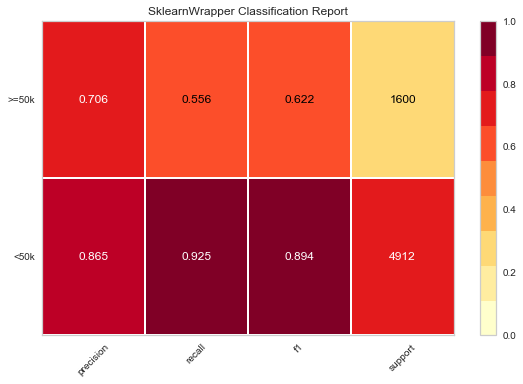

In [10]:
visualizer = yb.classifier.ClassificationReport(wrapped_learn, classes=classes, support=True)
visualizer.score(X_test, y_test)
visualizer.poof();

---

### [Class prediction error](https://www.scikit-yb.org/en/latest/api/classifier/class_prediction_error.html#class-prediction-error)

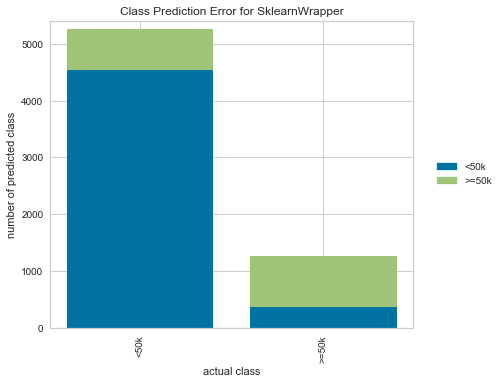

In [11]:
visualizer = yb.classifier.ClassPredictionError(wrapped_learn, classes=classes)
visualizer.score(X_test, y_test)
visualizer.poof();

----

### [ROC Curve](https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html#rocauc)

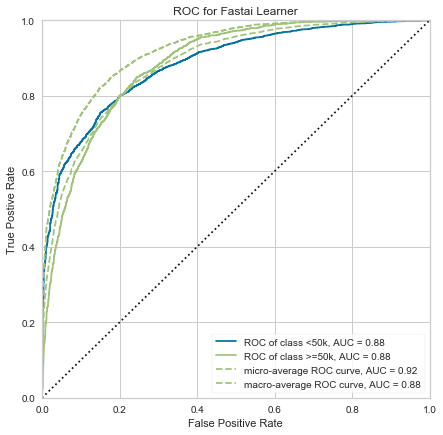

In [12]:
visualizer = yb.classifier.ROCAUC(wrapped_learn,
                                  classes=classes,
                                  size=[500,500],
                                  title="ROC for Fastai Learner")
visualizer.score(X_test, y_test)
visualizer.poof();

----

### [Precision-Recall Curve](https://www.scikit-yb.org/en/latest/api/classifier/prcurve.html)

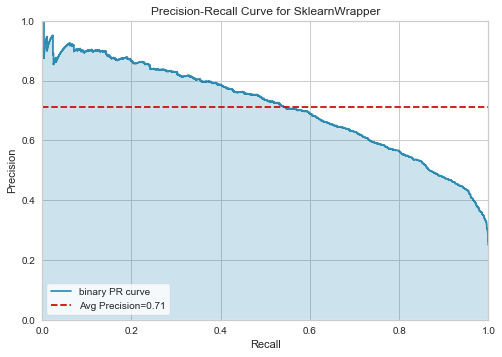

In [13]:
visualizer = yb.classifier.PrecisionRecallCurve(wrapped_learn)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

---

### [Disrcimination threshold](https://www.scikit-yb.org/en/latest/api/classifier/threshold.html#discrimination-threshold)

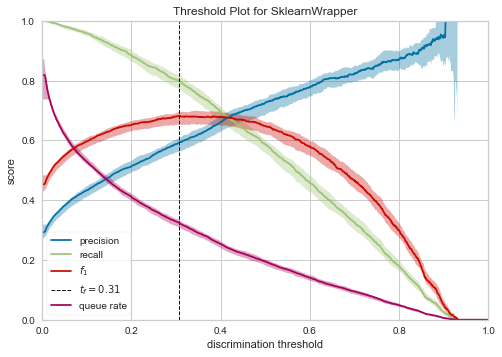

In [14]:
visualizer = yb.classifier.DiscriminationThreshold(wrapped_learn)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

----

### [Features ranking](https://www.scikit-yb.org/en/latest/api/features/rankd.html#rank-2d)

In [15]:
from yellowbrick.features import rank1d, rank2d

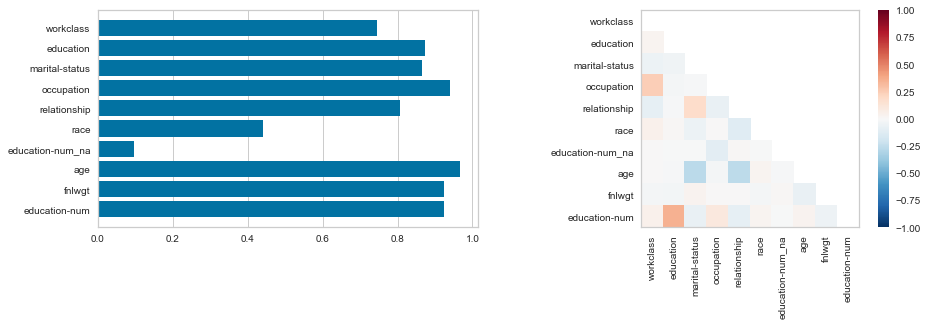

In [16]:
_, axes = plt.subplots(ncols=2, figsize=(15,4))
rank1d(X_train, ax=axes[0])
rank2d(X_train, ax=axes[1])
plt.show();